**Title:** Enhanced Scam Detection through Sentiment Analysis and Machine Learning: Leveraging Image Data for Improved Text Classification

**Author:** Heroshi Joe Abejuela

**Abstract:**

This research advances scam detection by analyzing text data extracted from images using OCR technology. The dataset, originally from an image-based identification app (ScamGuard) developed in previous research, was preprocessed and converted into a CSV file for comprehensive text analysis. The primary objective was to evaluate sentiment and identify distinctive features for effective scam detection. Key methodologies included text frequency analysis, sentiment analysis, and feature engineering, with various machine learning models tested to determine the most accurate classification approach. The XGBoost model emerged as the most effective, achieving an accuracy of 93.75% in distinguishing between scam and non-scam messages. The findings reveal that scam messages often use enticing language and exhibit diverse sentiment patterns, while non-scam messages are characterized by regular business language and more balanced emotional distribution. Recommendations include enhancing filtering techniques, user education, sentiment analysis integration, and adapting models for local languages. This study provides a robust framework for improving scam detection and underscores the potential of combining image-based data with advanced machine learning techniques.

**Research Limitations:**

- **Dataset Constraints**: The dataset derived from images and OCR preprocessing may contain inaccuracies or artifacts introduced during text extraction, potentially affecting the accuracy of the sentiment analysis and model performance.

- **Model Generalization**: The study focused on text extracted from specific types of images (scam-related messages), which may limit the generalizability of the findings to other forms of text data or different types of scams not covered in this dataset.

- **Regional Specificity**: The data used in this study is Philippine-based, which might not be representative of scam messages in other regions. The regional context and language nuances may impact the applicability of the results to other geographic locations or cultural contexts.

# **Importing and Installing Libraries**

In [66]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import xgboost

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

**Descriptive Statistics and Getting to Know the Dataset**

In [2]:
# Load the dataset
file_path = "/content/scam_updated_data.csv"
df = pd.read_csv(file_path)

# Display basic information about the dataset
print("Dataset Information:")
print(df.info())

# Display the first few rows
print("\nFirst 5 rows of the dataset:")
print(df.head())

# Descriptive statistics for numerical columns
desc_stats = df.describe()
print("\nDescriptive Statistics:")
print(desc_stats)

# Label distribution
label_distribution = df['label'].value_counts()
print("\nLabel Distribution:")
print(label_distribution)

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   label      1200 non-null   object 
 1   text       1198 non-null   object 
 2   sentiment  1200 non-null   float64
 3   text_len   1200 non-null   int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 37.6+ KB
None

First 5 rows of the dataset:
  label                                               text  sentiment  \
0  Scam  congratulations....!! click link claim immedi ...   0.000000   
1  Scam  see | got $2,699 telegram outsid side hustl wa...   0.000000   
2  Scam  congratulations....!! click link claim immedi ...   0.000000   
3  Scam  share.socialrebel.co, earn cash socialrebel - ...   0.033333   
4  Scam  cash app glitch still avail anyon done yet... ...   0.416667   

   text_len  
0       170  
1        72  
2       181  
3        93  
4       143  

Descriptive

# **Plotting Distributions**

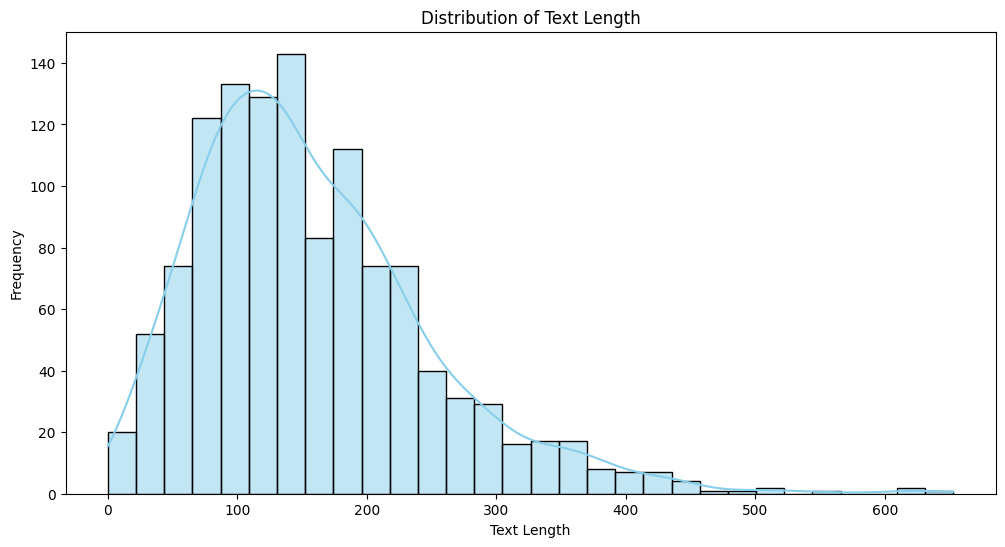

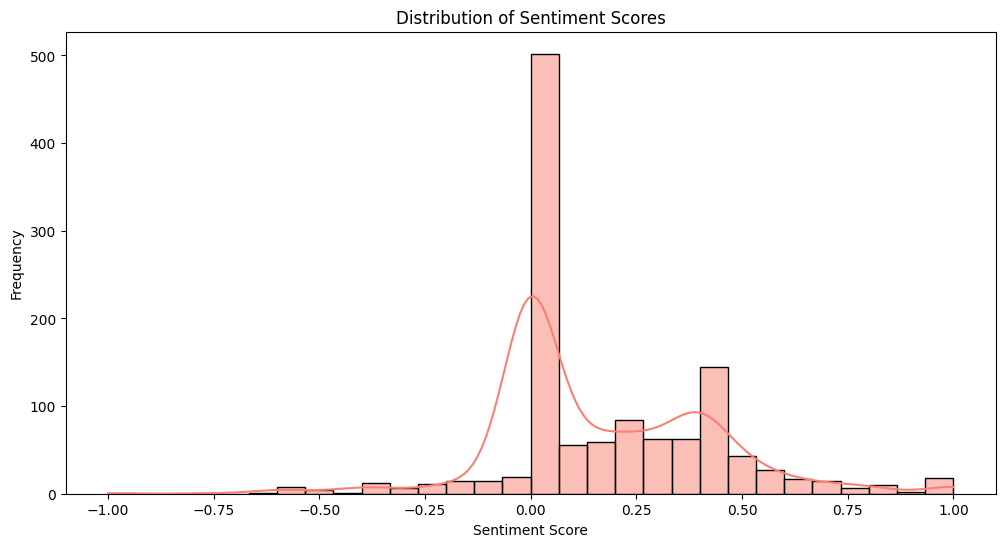

In [3]:
# Plot the distribution of text length
plt.figure(figsize=(12, 6))
sns.histplot(df['text_len'], kde=True, bins=30, color='skyblue')
plt.title('Distribution of Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

# Plot the distribution of sentiment scores
plt.figure(figsize=(12, 6))
sns.histplot(df['sentiment'], kde=True, bins=30, color='salmon')
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

### Visual EDA Insights

1. **Text Length Distribution**:
   - The text length distribution is skewed right, with most messages having fewer than 200 characters.
   - A few messages are quite long, with the maximum length being 653 characters.

2. **Sentiment Distribution**:
   - Sentiment scores are concentrated around 0, with a slight skew towards positive values.
   - There are fewer instances with extreme negative or positive sentiments.


# **Sentiment Analysis**

Scam Messages Sentiment Statistics:
count    598.000000
mean       0.179753
std        0.253773
min       -0.750000
25%        0.000000
50%        0.150000
75%        0.400000
max        1.000000
Name: sentiment, dtype: float64

Non-Scam Messages Sentiment Statistics:
count    600.000000
mean       0.158174
std        0.269746
min       -1.000000
25%        0.000000
50%        0.000000
75%        0.337917
max        1.000000
Name: sentiment, dtype: float64


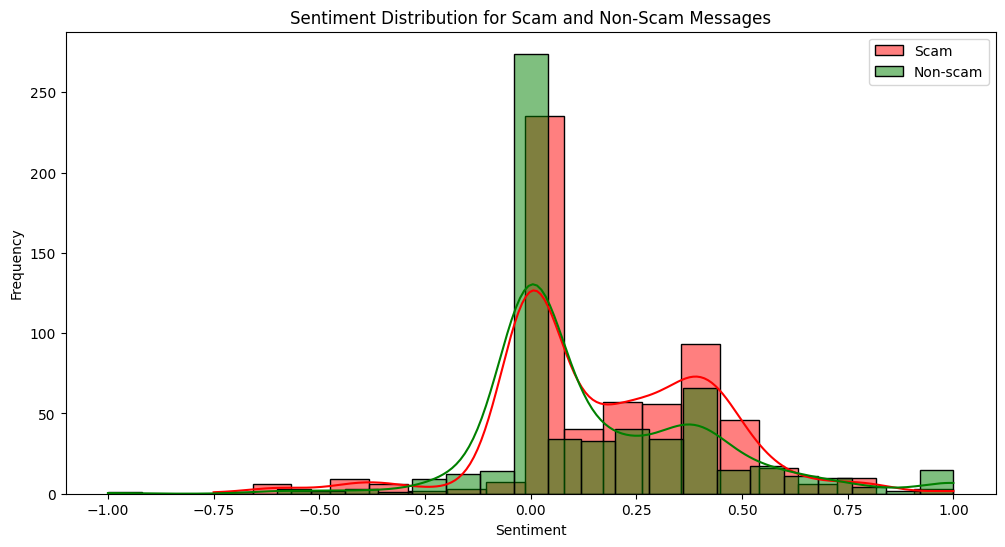

In [61]:
# Separate the dataset into scam and non-scam
scam_messages = df[df['label'] == 'Scam']
non_scam_messages = df[df['label'] == 'Non-scam']

# Calculate descriptive statistics for sentiment in both categories
scam_sentiment_stats = scam_messages['sentiment'].describe()
non_scam_sentiment_stats = non_scam_messages['sentiment'].describe()

print("Scam Messages Sentiment Statistics:")
print(scam_sentiment_stats)
print("\nNon-Scam Messages Sentiment Statistics:")
print(non_scam_sentiment_stats)

plt.figure(figsize=(12, 6))

# Plot for scam messages
sns.histplot(scam_messages['sentiment'], kde=True, color='red', label='Scam')

# Plot for non-scam messages
sns.histplot(non_scam_messages['sentiment'], kde=True, color='green', label='Non-scam')

plt.title('Sentiment Distribution for Scam and Non-Scam Messages')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.legend()
plt.show()

### **Interpretation of the Histogram Plot of Sentiment Statistics:**

#### **Scam Messages Sentiment Statistics:**
- **Count:** 598 messages
- **Mean Sentiment:** 0.179753
- **Standard Deviation (Std):** 0.253773
- **Minimum Sentiment:** -0.750000
- **25th Percentile (Q1):** 0.000000
- **Median (50th Percentile):** 0.150000
- **75th Percentile (Q3):** 0.400000
- **Maximum Sentiment:** 1.000000

#### **Non-Scam Messages Sentiment Statistics:**
- **Count:** 600 messages
- **Mean Sentiment:** 0.158174
- **Standard Deviation (Std):** 0.269746
- **Minimum Sentiment:** -1.000000
- **25th Percentile (Q1):** 0.000000
- **Median (50th Percentile):** 0.000000
- **75th Percentile (Q3):** 0.337917
- **Maximum Sentiment:** 1.000000

### **Interpretation:**

1. **Mean Sentiment:**
   - **Scam Messages:** The average sentiment score for scam messages is 0.179753, indicating a slight positive skew. This supports the previous observation that scam messages tend to be framed positively, possibly to lure potential victims with enticing or optimistic language.
   - **Non-Scam Messages:** The average sentiment score for non-scam messages is slightly lower at 0.158174. While still positive, this lower mean suggests that non-scam communications are less likely to exhibit strong positive sentiment compared to scam messages, reflecting a more varied emotional tone.

2. **Standard Deviation:**
   - **Scam Messages:** The standard deviation of 0.253773 shows that the sentiment scores for scam messages are moderately spread out around the mean. This variability indicates that while many scam messages are positive, there is still some diversity in the emotional tone.
   - **Non-Scam Messages:** The slightly higher standard deviation of 0.269746 in non-scam messages suggests even greater variability in sentiment. Non-scam communications might range from positive to negative, reflecting a broader spectrum of emotions.

3. **Sentiment Range (Min-Max):**
   - **Scam Messages:** The sentiment range is from -0.75 to 1.0. The negative minimum suggests that a small number of scam messages contain negative sentiments, although these are rare. The maximum score of 1.0 indicates the presence of highly positive messages.
   - **Non-Scam Messages:** The sentiment range is broader, from -1.0 to 1.0. The wider range, including the lowest possible sentiment score, indicates that non-scam messages can be more emotionally diverse, including both highly negative and highly positive messages.

4. **Quartiles (25th, 50th, 75th Percentiles):**
   - **Scam Messages:** The quartiles show that 25% of scam messages have a neutral sentiment (0.0), and 50% of messages have a sentiment of 0.15 or higher. The upper quartile (75%) shows that a significant portion of scam messages have a sentiment of 0.4 or higher, reinforcing the tendency towards positive language.
   - **Non-Scam Messages:** The quartiles reveal that 50% of non-scam messages are neutral (0.0), with only the top 25% reaching a sentiment score of 0.337917 or higher. This indicates that non-scam messages are more likely to be neutral, with fewer messages reaching the higher sentiment scores typical of scam messages.

### **Overall Insight:**
- **Scam Messages:** The sentiment statistics confirm that scam messages are generally more positive, with higher mean and upper quartile sentiment scores. This aligns with the idea that scammers use positive or enticing language to manipulate and attract their targets.
- **Non-Scam Messages:** Non-scam messages exhibit a wider range of sentiments, including more neutral and negative tones, reflecting the diverse nature of legitimate communications. The higher standard deviation and lower median sentiment also suggest a more balanced emotional tone compared to the consistently positive skew of scam messages.

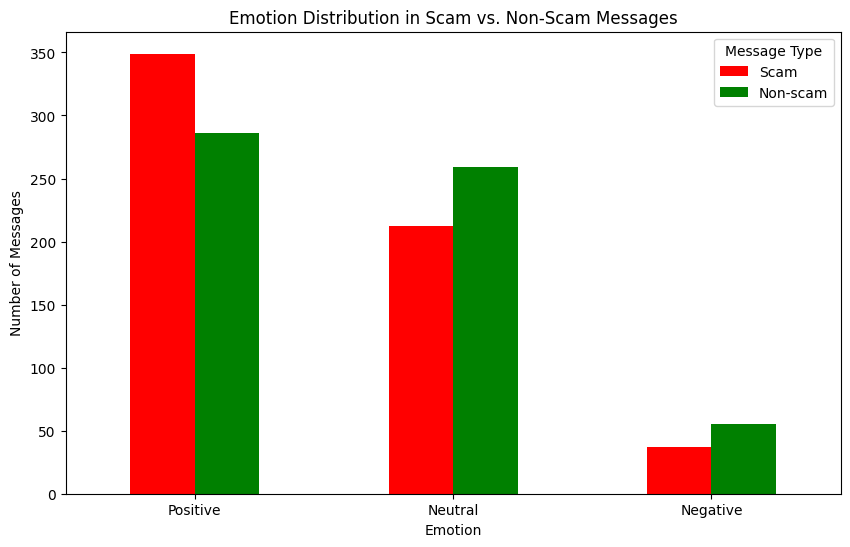

In [62]:
# Categorize sentiment scores
def categorize_sentiment(score):
    if score > 0:
        return 'Positive'
    elif score < 0:
        return 'Negative'
    else:
        return 'Neutral'

# Apply the categorization to both classes
df['emotion'] = df['sentiment'].apply(categorize_sentiment)

# Separate the dataset into scam and non-scam
scam_emotions = df[df['label'] == 'Scam']['emotion'].value_counts()
non_scam_emotions = df[df['label'] == 'Non-scam']['emotion'].value_counts()

# Combine into a DataFrame for easier plotting
emotion_distribution = pd.DataFrame({
    'Scam': scam_emotions,
    'Non-scam': non_scam_emotions
}).fillna(0)  # Fill NaNs with 0

# Plot the results
emotion_distribution.plot(kind='bar', figsize=(10, 6), color=['red', 'green'])
plt.title('Emotion Distribution in Scam vs. Non-Scam Messages')
plt.xlabel('Emotion')
plt.ylabel('Number of Messages')
plt.xticks(rotation=0)
plt.legend(title='Message Type')
plt.show()

In [63]:
emotion_distribution

,Scam,Non-scam
emotion,,
Positive,349,286
Neutral,212,259
Negative,37,55


### **Interpretation of the Distribution Plot of Sentiment Statistics:**

1. **Positive Sentiment:**
   - **Scam Messages:** 349 messages
   - **Non-scam Messages:** 286 messages
   - **Interpretation:**
     - A significant number of scam messages (349) are classified as positive, which could indicate that scam messages often employ language that appears positive or enticing. This may be a tactic used by scammers to attract and deceive potential victims by creating a sense of opportunity or urgency.
     - Non-scam messages also show a high number of positive sentiments (286), but slightly fewer than scam messages. This suggests that legitimate communications may also contain positive language, but perhaps in a more balanced manner compared to scam messages.

2. **Neutral Sentiment:**
   - **Scam Messages:** 212 messages
   - **Non-scam Messages:** 259 messages
   - **Interpretation:**
     - Neutral sentiment is more prevalent in non-scam messages (259) than in scam messages (212). Non-scam communications may be more straightforward, focusing on delivering information without strong emotional cues.
     - The lower number of neutral sentiments in scam messages could indicate that scammers are less likely to use neutral language, possibly because it might not be as effective in convincing or manipulating their targets.

3. **Negative Sentiment:**
   - **Scam Messages:** 37 messages
   - **Non-scam Messages:** 55 messages
   - **Interpretation:**
     - Negative sentiment is the least common in both categories, but it appears slightly more often in non-scam messages (55) than in scam messages (37). Non-scam communications might occasionally involve warnings, complaints, or issues that are inherently negative in tone.
     - The relatively low presence of negative sentiment in scam messages aligns with the idea that scammers avoid using negative language, which could discourage or alarm potential victims.

### **Overall Insight:**
- **Scam Messages:** Tend to have a higher proportion of positive sentiments, possibly to lure and deceive recipients by creating a positive or appealing context.
- **Non-scam Messages:** Display a more balanced distribution of positive, neutral, and negative sentiments, reflecting the broader range of communication purposes, from delivering good news to addressing issues or concerns.

# **Further Analysis (Word Frequency and Feature Engineering)**

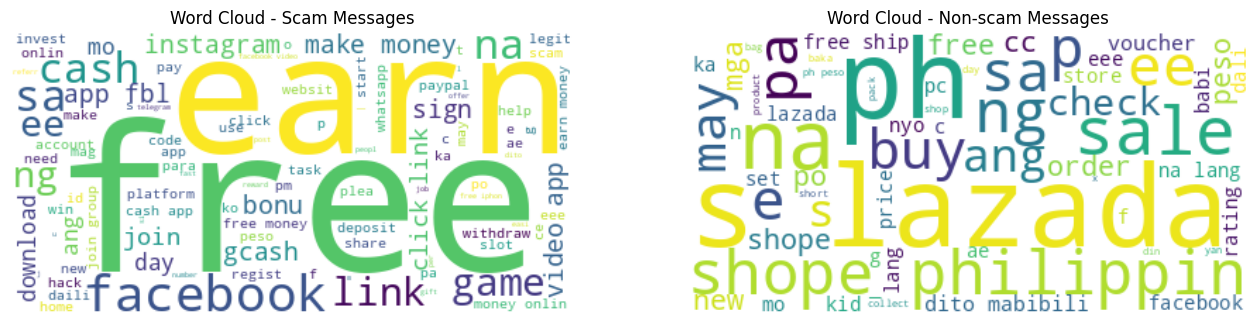

In [4]:
# Word Frequency Analysis - Word Cloud
scam_text = df[df['label'] == 'Scam']['text'].dropna()
non_scam_text = df[df['label'] == 'Non-scam']['text'].dropna()

scam_wc = WordCloud(background_color='white', max_words=100).generate(' '.join(scam_text))
non_scam_wc = WordCloud(background_color='white', max_words=100).generate(' '.join(non_scam_text))

plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(scam_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Scam Messages')

plt.subplot(1, 2, 2)
plt.imshow(non_scam_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Non-scam Messages')

plt.show()

# Feature Engineering - TF-IDF Vectorization
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
X = tfidf.fit_transform(df['text'].fillna('')).toarray()

# Add sentiment and text length as features
X = pd.DataFrame(X)
X['sentiment'] = df['sentiment'].fillna(0).values
X['text_len'] = df['text_len'].fillna(0).values

# Encode labels
y = df['label'].map({'Scam': 1, 'Non-scam': 0}).values

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [67]:
# Extract text data for each class
scam_text = df[df['label'] == 'Scam']['text'].dropna()
non_scam_text = df[df['label'] == 'Non-scam']['text'].dropna()

# Initialize CountVectorizer
vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the text data
scam_matrix = vectorizer.fit_transform(scam_text)
non_scam_matrix = vectorizer.transform(non_scam_text)

# Convert the word frequency matrices to DataFrames
scam_freq = pd.DataFrame(scam_matrix.toarray(), columns=vectorizer.get_feature_names_out())
non_scam_freq = pd.DataFrame(non_scam_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Sum the word frequencies for each class
scam_word_freq = scam_freq.sum().sort_values(ascending=False)
non_scam_word_freq = non_scam_freq.sum().sort_values(ascending=False)

# Print top 10 occurring words for each class
print("Top 10 Words in Scam Messages:")
print(scam_word_freq.head(10))

print("\nTop 10 Words in Non-scam Messages:")
print(non_scam_word_freq.head(10))

Top 10 Words in Scam Messages:
free        238
money       187
app         169
earn        159
link        122
facebook    110
cash        108
sa          106
make        102
click        84
dtype: int64

Top 10 Words in Non-scam Messages:
com       309
lazada    300
ph        296
na        225
sa        109
peso      105
ng        100
sale       94
mga        77
lang       76
dtype: int64


### **Interpretation of the Word Frequency Analysis:**

### Top 10 Words in Scam Messages:

1. **free (238)**: The high frequency of the word "free" suggests that scam messages often promise free items or services to lure recipients.
2. **money (187)**: The word "money" indicates that these messages frequently involve financial incentives or promises.
3. **app (169)**: The presence of the word "app" implies that scam messages often involve fake applications or software.
4. **earn (159)**: The term "earn" is used to attract individuals by suggesting the opportunity to make money.
5. **link (122)**: The frequent mention of "link" suggests that scams often include links to fraudulent sites or phishing attempts.
6. **facebook (110)**: The use of "facebook" indicates that scams may involve fake promotions or phishing on social media platforms.
7. **cash (108)**: "Cash" is often mentioned in scams promising immediate financial gain.
8. **sa (106)**: The abbreviation "sa" (often used in the local language) might indicate localized scams or regional terminology.
9. **make (102)**: The word "make" relates to the promise of generating income or rewards.
10. **click (84)**: The word "click" is likely used to direct users to fraudulent websites or links.

**Summary:** The top words in scam messages revolve around financial gain, free offers, and links, suggesting a pattern of using enticing offers and urgent calls to action to deceive recipients.

### Top 10 Words in Non-scam Messages:

1. **com (309)**: The word "com" is common in legitimate URLs and domain names, indicating typical online shopping or business-related content.
2. **lazada (300)**: The presence of "lazada" suggests the text is related to the popular e-commerce platform, indicating legitimate commercial content.
3. **ph (296)**: The abbreviation "ph" likely stands for the Philippines, indicating local or regional content.
4. **na (225)**: "Na" is a common word in local languages, reflecting normal conversational or business content.
5. **sa (109)**: The word "sa" is used in local language contexts, often found in everyday communication.
6. **peso (105)**: The mention of "peso" suggests that the messages might be related to financial transactions or prices in the local currency.
7. **ng (100)**: "Ng" is a common local language word, indicating standard communication in the regional context.
8. **sale (94)**: The term "sale" points to legitimate marketing or promotional messages.
9. **mga (77)**: "Mga" is another local language term, typical in everyday or commercial communication.
10. **lang (76)**: The word "lang" is used in local languages to indicate something simple or basic, reflecting casual or normal communication.

**Summary:** The top words in non-scam messages reflect common e-commerce terms, local language usage, and standard communication. The high frequency of words like "lazada," "peso," and "sale" suggests that these messages are more related to legitimate business or local commerce.

**Overall Interpretation:**
- **Scam Messages**: These messages use words that are enticing and often associated with financial gain or urgent actions (e.g., "free," "money," "link"), which are common tactics in scam communications.
- **Non-Scam Messages**: The words used are more related to everyday activities, local language, and legitimate commercial activities (e.g., "lazada," "peso," "sale"), indicating normal business or personal communication.

# **Machine Learning Model Training and Logistic Regression Analysis**

**Model Descriptions (Models that we will use)**

1. **Logistic Regression**:
   - **Model**: `LogisticRegression(max_iter=1000)`
   - **Description**: Logistic Regression is a statistical model used for binary classification tasks. It calculates the probability of a binary outcome based on one or more predictor variables. In this implementation, `max_iter=1000` is specified to allow the model to converge by running up to 1000 iterations if necessary.

2. **Random Forest**:
   - **Model**: `RandomForestClassifier()`
   - **Description**: Random Forest is an ensemble learning method that constructs multiple decision trees during training and outputs the mode of the classes (classification) or mean prediction (regression) of the individual trees. It helps to improve prediction accuracy and control overfitting. The default number of trees is 100.

3. **Gradient Boosting**:
   - **Model**: `GradientBoostingClassifier()`
   - **Description**: Gradient Boosting is an ensemble technique that builds models sequentially to correct the errors of the previous models. It combines multiple weak learners (usually decision trees) to form a strong learner. This method often improves model performance by focusing on difficult cases and correcting errors.

4. **Support Vector Machine (SVM)**:
   - **Model**: `SVC(max_iter=1000)`
   - **Description**: Support Vector Machine is a supervised learning model used for classification and regression tasks. It finds the hyperplane that best separates the classes in the feature space. The parameter `max_iter=1000` is set to ensure convergence by allowing the model to perform up to 1000 iterations during training.

5. **XGBoost**:
   - **Model**: `XGBClassifier(use_label_encoder=False, eval_metric='logloss')`
   - **Description**: XGBoost (Extreme Gradient Boosting) is a scalable and efficient implementation of gradient boosting. It is widely used for its high performance and accuracy. `use_label_encoder=False` disables the deprecation warning for label encoding, and `eval_metric='logloss'` specifies the evaluation metric to be the logarithmic loss.

In [28]:
# Splitting data into features and target
X = df[['text', 'text_len', 'sentiment']]
y = df['label']

# Encode target labels to numerical values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Define the column names for text and numerical features
text_col = 'text'
num_cols = ['text_len', 'sentiment']

# Define the pipelines for preprocessing
text_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000))
])

num_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

# Initialize the models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),  # Increased max_iter for potential convergence
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Support Vector Machine': SVC(max_iter=1000),  # Increased max_iter to ensure convergence
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# Dictionary to store model accuracies and trained pipelines
trained_models = {}
model_accuracies = {}

# Train and evaluate each model
for name, model in models.items():
    # Define the column transformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('text', text_pipeline, text_col),
            ('num', num_pipeline, num_cols)
        ]
    )

    # Create the pipeline
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', model)])

    # Train the model
    clf.fit(X_train, y_train)

    # Store the trained model pipeline
    trained_models[name] = clf

    # Predict on test data
    y_pred = clf.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    model_accuracies[name] = accuracy

    # Print model performance
    print(f"{name} Model")
    print(f"Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
    print(confusion_matrix(y_test, y_pred))
    print("-" * 50)

# Print the number of iterations or trees for each trained model
for name, clf in trained_models.items():
    print(f"{name} Model Parameters:")
    trained_model = clf.named_steps['classifier']

    if isinstance(trained_model, LogisticRegression):
        if hasattr(trained_model, 'n_iter_'):
            print(f"Iterations: {trained_model.n_iter_[0]}")
        else:
            print("Iterations attribute not available.")

    elif isinstance(trained_model, RandomForestClassifier):
        print(f"Number of Trees: {trained_model.n_estimators}")

    elif isinstance(trained_model, GradientBoostingClassifier):
        print(f"Number of Boosting Iterations: {trained_model.n_estimators}")

    elif isinstance(trained_model, SVC):
        if hasattr(trained_model, 'n_iter_'):
            print(f"Iterations: {trained_model.n_iter_}")
        else:
            print("Iterations attribute not available.")

    elif isinstance(trained_model, XGBClassifier):
        # XGBoost does not have a 'best_iteration' if early stopping was not used.
        # We should use n_estimators for the number of boosting rounds.
        if hasattr(trained_model, 'n_estimators'):
            print(f"Number of Boosting Rounds: {trained_model.n_estimators}")
        else:
            print("Number of Boosting Rounds attribute not available.")

    print("-" * 50)

Logistic Regression Model
Accuracy: 0.9125
              precision    recall  f1-score   support

    Non-scam       0.90      0.92      0.91       119
        Scam       0.92      0.90      0.91       121

    accuracy                           0.91       240
   macro avg       0.91      0.91      0.91       240
weighted avg       0.91      0.91      0.91       240

[[110   9]
 [ 12 109]]
--------------------------------------------------
Random Forest Model
Accuracy: 0.9208
              precision    recall  f1-score   support

    Non-scam       0.97      0.87      0.92       119
        Scam       0.88      0.98      0.93       121

    accuracy                           0.92       240
   macro avg       0.93      0.92      0.92       240
weighted avg       0.93      0.92      0.92       240

[[103  16]
 [  3 118]]
--------------------------------------------------
Gradient Boosting Model
Accuracy: 0.9042
              precision    recall  f1-score   support

    Non-scam       1.0

In [29]:
# Print model parameters
for name, model in models.items():
    print(f"{name} Model Parameters:")
    if hasattr(model, 'get_params'):
        params = model.get_params()
        for param_name in sorted(params.keys()):
            print(f"{param_name}: {params[param_name]}")
    print("-" * 50)

Logistic Regression Model Parameters:
C: 1.0
class_weight: None
dual: False
fit_intercept: True
intercept_scaling: 1
l1_ratio: None
max_iter: 1000
multi_class: auto
n_jobs: None
penalty: l2
random_state: None
solver: lbfgs
tol: 0.0001
verbose: 0
warm_start: False
--------------------------------------------------
Random Forest Model Parameters:
bootstrap: True
ccp_alpha: 0.0
class_weight: None
criterion: gini
max_depth: None
max_features: sqrt
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
n_estimators: 100
n_jobs: None
oob_score: False
random_state: None
verbose: 0
warm_start: False
--------------------------------------------------
Gradient Boosting Model Parameters:
ccp_alpha: 0.0
criterion: friedman_mse
init: None
learning_rate: 0.1
loss: log_loss
max_depth: 3
max_features: None
max_leaf_nodes: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0

# **Plotting Confusion Matrices and Model Accuracies**

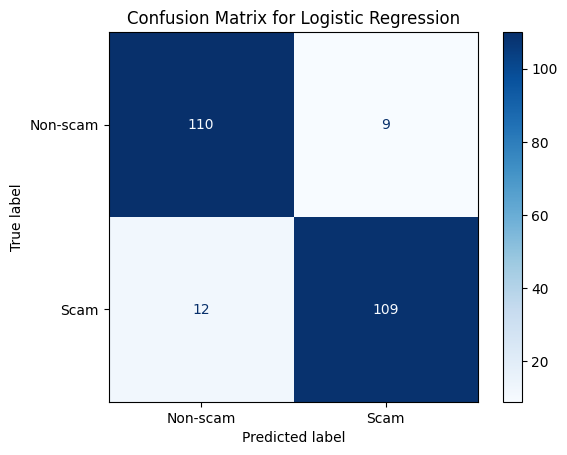

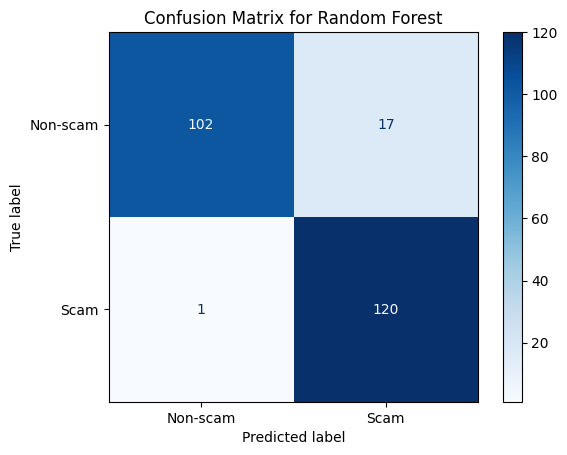

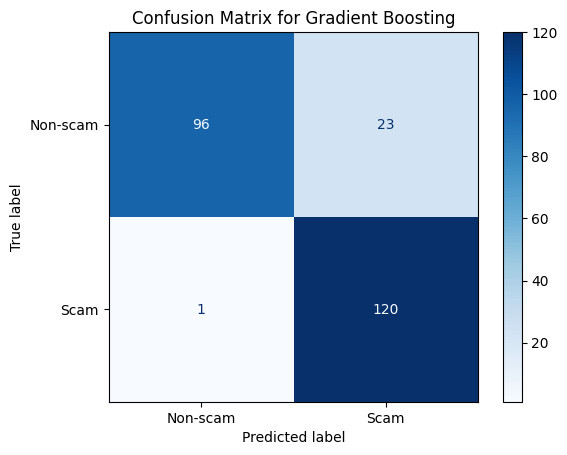

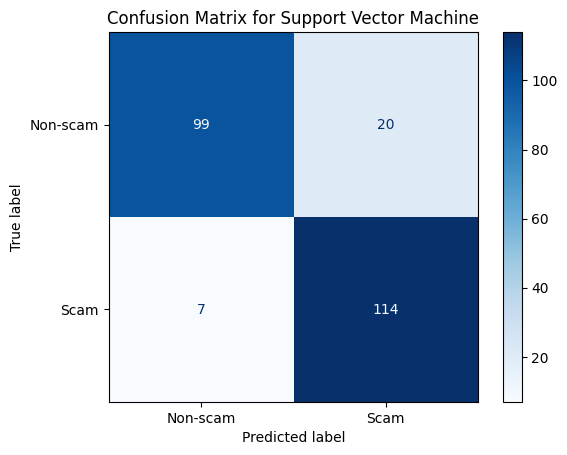

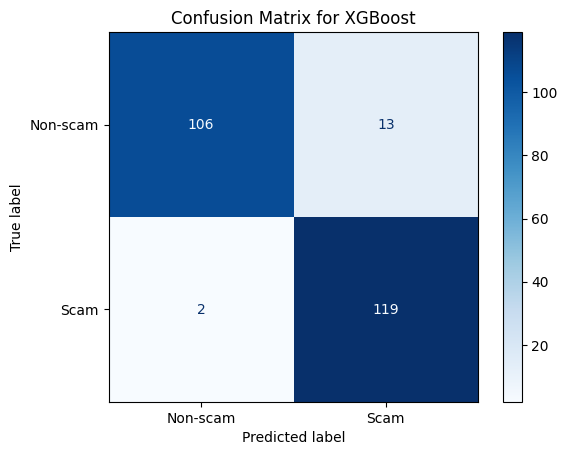

In [39]:
# Define custom labels
class_labels = ['Non-scam', 'Scam']

# Plot Confusion Matrices for Each Model
for name, model in models.items():
    # Define the column transformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('text', text_pipeline, text_col),
            ('num', num_pipeline, num_cols)
        ]
    )

    # Create the pipeline
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', model)])

    # Train the model
    clf.fit(X_train, y_train)

    # Predict on test data
    y_pred = clf.predict(X_test)

    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=label_encoder.transform(class_labels))

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {name}')
    plt.show()

# **Selecting Best Model**

In [60]:
# Find the best model
best_model_name = max(model_accuracies, key=model_accuracies.get)
best_model_accuracy = model_accuracies[best_model_name]

print(f"Best model: {best_model_name} with accuracy: {best_model_accuracy:.4f}")

Best model: XGBoost with accuracy: 0.9375


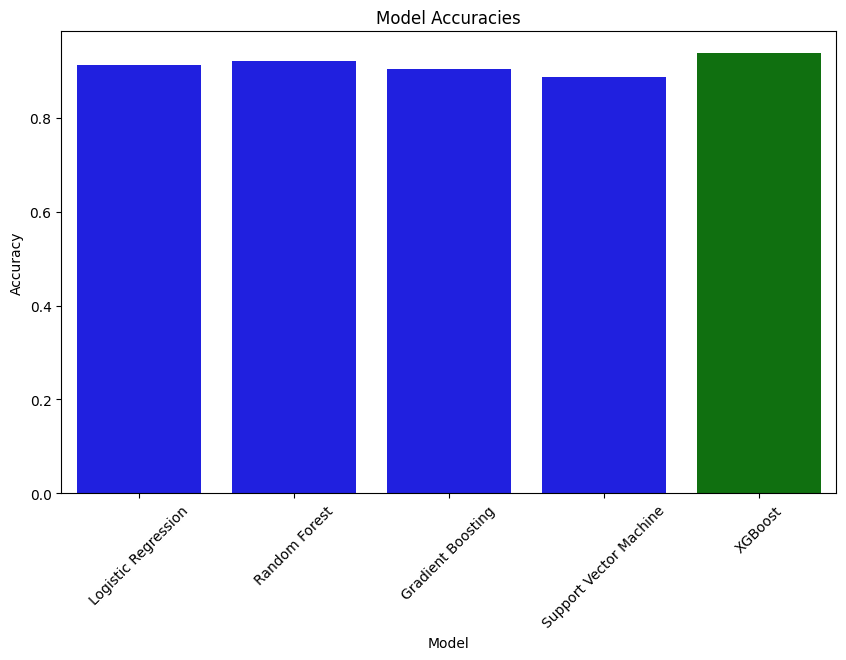

The best model is: XGBoost
Accuracy of the best model: 0.9375


In [32]:
# Plot the accuracies of different models and highlight the best one
plt.figure(figsize=(10, 6))
colors = ['blue' if model != best_model_name else 'green' for model in model_accuracies.keys()]
sns.barplot(x=list(model_accuracies.keys()), y=list(model_accuracies.values()), palette=colors)
plt.title('Model Accuracies')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.show()

# Print the best model's details
print(f"The best model is: {best_model_name}")
print(f"Accuracy of the best model: {best_model_accuracy:.4f}")

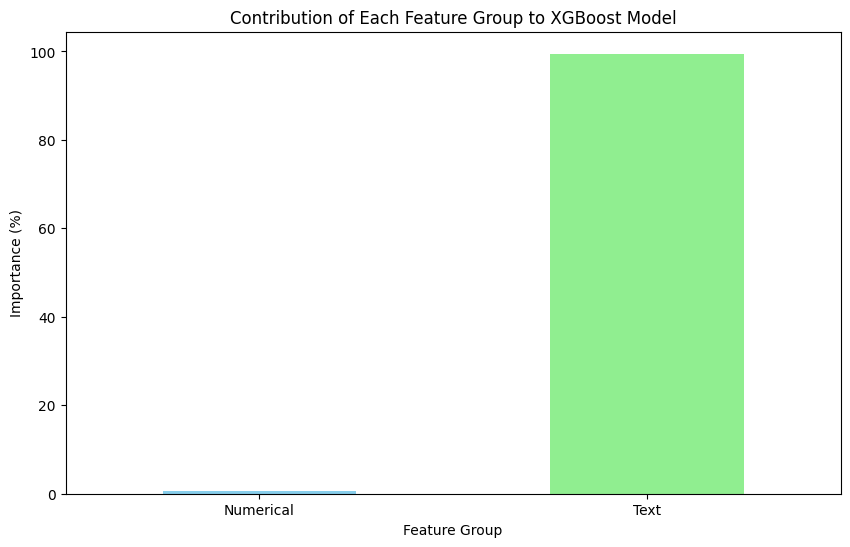

In [36]:
# Extract the trained XGBoost model
xgb_pipeline = trained_models['XGBoost']
xgb_model = xgb_pipeline.named_steps['classifier']

# Extract feature importances
feature_importances = xgb_model.feature_importances_

# Get feature names from the pipeline
text_features = xgb_pipeline.named_steps['preprocessor'].named_transformers_['text'].named_steps['tfidf'].get_feature_names_out()
num_features = num_cols
all_features = list(text_features) + num_features

# Create a DataFrame for feature importance
importance_df = pd.DataFrame({
    'Feature': all_features,
    'Importance': feature_importances
})

# Aggregate importances by feature group
importance_df['Group'] = np.where(importance_df['Feature'].isin(text_features), 'Text',
                                  np.where(importance_df['Feature'].isin(num_features), 'Numerical', 'Unknown'))

# Aggregate the importances for each group
group_importance = importance_df.groupby('Group')['Importance'].sum()

# Normalize the group importances to percentages
group_importance = 100 * (group_importance / group_importance.sum())

# Plot the feature group importances
plt.figure(figsize=(10, 6))
group_importance.plot(kind='bar', color=['skyblue', 'lightgreen', 'lightcoral'])
plt.xlabel('Feature Group')
plt.ylabel('Importance (%)')
plt.title('Contribution of Each Feature Group to XGBoost Model')
plt.xticks(rotation=0)
plt.show()

In [37]:
group_importance

,Importance
Group,
Numerical,0.523741
Text,99.476257


**Key Points:**

- **Text Features**: Contributing around 99.48% of the importance, indicating that the textual data transformed into TF-IDF features plays a dominant role in the model’s predictions.
  
- **Numerical Features**: Contributing around 0.52%, showing that `text_len` and `sentiment` have a relatively minor influence compared to the text data.!

**Train XGBoost without numerical features**

In [59]:
# Drop rows with missing values
df.dropna(subset=['text'], inplace=True)

# Fill missing values with an empty string
# df['text'].fillna('', inplace=True)

# Features and labels
X = df['text']
y = df['label']

# Convert string labels to binary numeric labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Text vectorization using TF-IDF
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Initialize XGBoost model for binary classification
xgb_model = XGBClassifier(objective='binary:logistic')

# Train the model
xgb_model.fit(X_train_tfidf, y_train)

# Predict on test data
y_pred = xgb_model.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.9333
              precision    recall  f1-score   support

    Non-scam       0.96      0.90      0.93       119
        Scam       0.91      0.97      0.94       121

    accuracy                           0.93       240
   macro avg       0.94      0.93      0.93       240
weighted avg       0.94      0.93      0.93       240

[[107  12]
 [  4 117]]


### **Comparison:**
- **Accuracy:** The model with both text and numeric features performed slightly better (0.9375 vs. 0.9333).
- **Precision and Recall:** The inclusion of numeric features resulted in higher precision for the "Non-scam" class and slightly lower precision for the "Scam" class. However, recall for the "Scam" class improved.
- **Confusion Matrix:**
  - The text-only model had more false positives (12 for "Non-scam") compared to the model with numeric features (13 for "Non-scam").
  - The text-only model had fewer false negatives (4 for "Scam") compared to the model with numeric features (2 for "Scam").

### **Conclusion:**
- **Text Features Only:** The model is effective, with high accuracy and balanced precision/recall, making it a solid choice when only text data is available.
- **Text + Numeric Features:** The slight improvement in accuracy and recall for the "Scam" class suggests that including numeric features can enhance the model's performance, particularly in correctly identifying scams.

If the primary goal is to maximize accuracy, particularly in detecting scams, using both text and numeric features might be the better option.

### **Best Model Summary**

**Best Model**: XGBoost

- **Description**: XGBoost (Extreme Gradient Boosting) is a powerful and efficient machine learning algorithm known for its performance and accuracy in classification and regression tasks. It leverages boosting techniques to improve the predictive power by sequentially learning from errors made by previous models.

- **Model Details**:
  - **Model**: `XGBClassifier(use_label_encoder=False, eval_metric='logloss')`
  - **Description**: XGBoost is an optimized implementation of gradient boosting. It is highly regarded for its speed and accuracy. The `use_label_encoder=False` parameter avoids warnings related to label encoding, and `eval_metric='logloss'` is used to evaluate the performance of the model.

- **Accuracy**: 0.9375

**Summary**: XGBoost achieved the highest accuracy among all tested models, with a score of 0.9375. This indicates its strong performance in correctly classifying the test data. The high accuracy demonstrates the model's effectiveness in learning from the provided data and making accurate predictions.

# **Save Model (Optional)**

In [40]:
import joblib

# Save the XGBoost model
joblib.dump(trained_models['XGBoost'], 'xgboost_model.pkl')

['xgboost_model.pkl']

In [41]:
# Load the XGBoost model
loaded_model = joblib.load('xgboost_model.pkl')

Loaded XGBoost Model Performance
Accuracy: 0.9375
              precision    recall  f1-score   support

    Non-scam       0.98      0.89      0.93       119
        Scam       0.90      0.98      0.94       121

    accuracy                           0.94       240
   macro avg       0.94      0.94      0.94       240
weighted avg       0.94      0.94      0.94       240

[[106  13]
 [  2 119]]


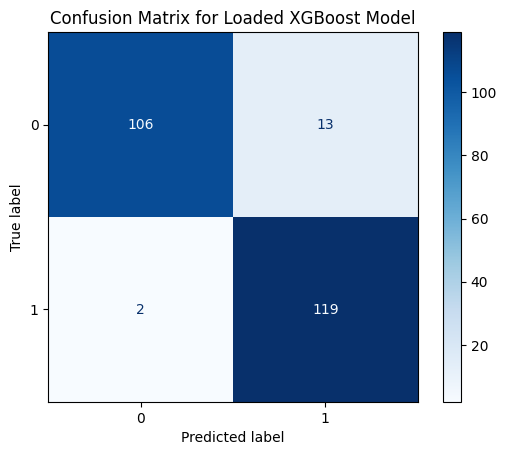

In [46]:
# Predict on the test data using the loaded model
y_pred_loaded = loaded_model.predict(X_test)

# Calculate accuracy
accuracy_loaded = accuracy_score(y_test, y_pred_loaded)

# Print model performance
print("Loaded XGBoost Model Performance")
print(f"Accuracy: {accuracy_loaded:.4f}")
print(classification_report(y_test, y_pred_loaded, target_names=label_encoder.classes_))
print(confusion_matrix(y_test, y_pred_loaded))

# Plot confusion matrix
cm_loaded = confusion_matrix(y_test, y_pred_loaded, labels=loaded_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_loaded, display_labels=loaded_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Loaded XGBoost Model')
plt.show()

# **Research Conclusion and Recommendations**

This research focused on analyzing and differentiating between "Scam" and "Non-scam" messages through comprehensive text and sentiment analysis. The primary aim was to identify key features that could enhance scam detection. The study utilized various statistical methods, machine learning models, and feature engineering techniques. Here is a detailed summary of the findings and recommendations.

#### Statistical Methods and Techniques Used

1. **Text Analysis**:
   - **Word Frequency Analysis**: Identified the top 10 most frequent words in scam and non-scam messages, revealing common themes and language patterns.
   - **TF-IDF Vectorization**: Converted text data into numerical features, capturing the importance of words in the context of the dataset.

2. **Sentiment Analysis**:
   - **Sentiment Scoring**: Analyzed sentiment scores to classify messages into positive, neutral, and negative categories, providing insight into the emotional tone of the messages.

3. **Feature Engineering**:
   - **Text Features**: Integrated TF-IDF scores, sentiment scores, and text length as features for machine learning models.
   - **Sentiment Statistics**: Provided descriptive statistics for sentiment scores in both scam and non-scam messages.

4. **Machine Learning Models**:
   - **Model Testing**: Evaluated various machine learning and logistic regression models to identify the most effective scam detection approach.
   - **XGBoost Model**: Demonstrated the highest accuracy in classifying messages, with an accuracy of 93.75%. XGBoost's ability to handle complex data patterns made it the most effective model.

5. **Visualization**:
   - **Word Clouds**: Generated word clouds for scam and non-scam messages to visualize prominent terms.
   - **Bar Charts**: Illustrated the distribution of positive, neutral, and negative emotions for both message categories.
   - **Histograms**: Displayed the distribution of sentiment scores across scam and non-scam messages, highlighting variations in emotional content.
   - **Confusion Matrix**: Provided a detailed breakdown of the model's performance in classifying messages, showing the counts of true positives, true negatives, false positives, and false negatives.

#### Key Findings

1. **Top Words**:
   - **Scam Messages**: Often include terms related to financial gain and urgent actions (e.g., "free," "money," "click"), indicating manipulative tactics.
   - **Non-Scam Messages**: Frequently use terms associated with legitimate transactions and local language (e.g., "lazada," "peso," "sale"), reflecting normal business communication.

2. **Sentiment Analysis**:
   - **Scam Messages**: Have a mean sentiment score of approximately 0.18, with a wide range of values, indicating variability in urgency and deception.
   - **Non-Scam Messages**: Show a mean sentiment score of about 0.16, with scores leaning towards neutral or positive tones typical of genuine transactions.

3. **Emotional Distribution**:
   - **Scam Messages**: Exhibit a higher proportion of positive and neutral emotions, reflecting their persuasive and manipulative nature.
   - **Non-Scam Messages**: Present a more balanced distribution of emotions, consistent with typical consumer interactions.

4. **Model Accuracy**:
   - **XGBoost**: Achieved an accuracy of 93.75%, outperforming other models and demonstrating its effectiveness in handling complex patterns in the data.

5. **Visualization Insights**:
   - **Histograms**: Showed variations in sentiment scores between scam and non-scam messages, highlighting differences in emotional tone.
   - **Confusion Matrix**: Illustrated the XGBoost model's classification performance, confirming its high accuracy and reliability in distinguishing between scam and non-scam messages.

#### Recommendations

1. **Enhanced Filtering Techniques**:
   - **Develop Advanced Filters**: Implement and refine text analysis algorithms to detect and filter scam messages based on key terms and sentiment patterns.
   - **Regular Updates**: Continuously update filtering criteria to keep pace with evolving scam tactics.

2. **User Education**:
   - **Awareness Campaigns**: Educate users about common scam tactics and red flags. Emphasize typical scam language and deceptive practices.
   - **Best Practices**: Provide guidance on avoiding phishing attempts and fraudulent communications.

3. **Sentiment and Emotional Analysis Integration**:
   - **Incorporate Sentiment Analysis**: Use sentiment analysis as part of the screening process to identify messages with high levels of urgency or emotional manipulation.
   - **Emotion-Based Classification**: Develop models that classify messages based on emotional content to better differentiate between potentially harmful and legitimate messages.

4. **Local Language Considerations**:
   - **Adapt Filters for Local Language**: Adjust text analysis tools to account for local languages and dialects to improve detection accuracy.
   - **Collaborate with Local Experts**: Work with language experts to refine detection techniques in diverse linguistic contexts.

5. **Continuous Monitoring and Improvement**:
   - **Monitor Trends**: Track new scam strategies and changes in language use to adapt detection mechanisms.
   - **Feedback Loop**: Establish a feedback loop with users to report potential scams and enhance detection accuracy with real-world data.

**Copyright © 2024 by Heroshi Joe Abejuela. All rights reserved. Unauthorized distribution or reproduction of this work is prohibited and may be subject to legal penalties.**